In [1]:
import operator
import math
import random

import numpy as np
from scipy import linalg

## import deap lib
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

## Import for 2D problem

from evaluate import Collocation2D,Collocation3D, Circle, StarLikeCurve, SphereBoundary, StarLikeSurface, BoundaryCondition, MFSHelper2D, MFSHelper3D

# General configuration

In [2]:
DIM_2D = True ## 2D - True, 3D - False

In [3]:
N = 512 # number of collocation points to calculate boundary data
Nstep = 8 # specify division step.
assert N % Nstep == 0

In [4]:
G1_DIRICHLET_COND = BoundaryCondition(lambda X: np.zeros(shape=(X.shape[1],1), dtype=float)) ## Dirichlet condition
G2_NEUMAN_COND = BoundaryCondition(lambda X: np.ones(shape=(X.shape[1],1), dtype=float)*3) ## Neuman condition

In [5]:
EXTERIOR_BOUNDARY_RADIUS = 5

In [6]:
EPS = 1e-12

### Radial function for interior boundary

In [7]:
# r_exact = lambda t: np.sqrt(np.sin(t)*np.cos(t) +1.5)
# r_exact = lambda t: np.sqrt(np.cos(t)**2 + (np.sin(t)**2)/4)
# r_exact = lambda t: 2+np.divide(np.cos(np.multiply(t,5)),5) + np.divide(np.sin(np.multiply(t,7)),4)
# r_exact = lambda t: 2 + np.sin(np.multiply(t,3))*(0.05 + np.cos(np.multiply(t,2)))
# r_exact = lambda t: 3.2975
if DIM_2D:
#     R_EXACT = lambda t: 2 + np.sin(np.multiply(t,3))*(0.05 + np.cos(np.multiply(t,2)))
    R_EXACT = lambda t: np.sqrt(np.cos(t)**2 + np.divide(np.sin(t)**2,4))
else:
#     R_EXACT = lambda theta, phi: 2 +  math.sqrt(4.25 + 3*math.cos(3*theta))
    R_EXACT = lambda theta, phi: 2 +  np.sqrt(4.25 + 3*np.cos(3*theta))
#     R_EXACT = lambda theta, phi: 2*np.sqrt(np.cos(2*theta)+ np.sqrt(2 - np.sin(2*theta)**2))

# Define test boundaries and calculate boundary values

In [8]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

### Define exterior boundary

In [9]:
if DIM_2D:
    G2_BOUNDARY = Circle(EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY(collocation.thetas)
    G1_BOUNDARY = StarLikeCurve()
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas),collocation.thetas) # Values in collocation points
else:
    G2_BOUNDARY = SphereBoundary(EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY(collocation.thetas, collocation.phis)
    G1_BOUNDARY = StarLikeSurface()
    G1_VALUES = G1_BOUNDARY(
        R_EXACT(collocation.thetas, collocation.phis),
        collocation.thetas, collocation.phis) # Values in collocation points

In [10]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)

## Find the Dirichlet data on Gamma2

In [11]:
# A =helper2D.form_matrix(g1_boundary(collocation2d.thetas))
# b = helper2D.form_column(g1_boundary(collocation2d.thetas))
# lambda_ = linalg.lstsq(A,b)[0]

A = HELPER.form_matrix(G1_VALUES.copy()) ## A = (2NxN)
b = HELPER.form_column(G1_VALUES.copy())
lambda_ = linalg.lstsq(A,b)[0]

In [12]:
G2_DIRICHLET_VALUES = HELPER.uApprox(lambda_, G2_VALUES.copy(), G1_VALUES.copy())

In [13]:
# # g2_dirichlet_values = helper2D.uApprox(lambda_,g2_boundary(collocation2d.thetas),g1_boundary(collocation2d.thetas))
# g2_dirichlet_values = helper2D.uApprox(lambda_,g2_boundary(collocation2d.thetas),g1_boundary(r_exact(collocation2d.thetas),collocation2d.thetas))

## Recalculate data

In [14]:
N = int(N/Nstep)

In [15]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

In [16]:
if DIM_2D:
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas),collocation.thetas)
else:
    G1_VALUES = G1_BOUNDARY(
        R_EXACT(collocation.thetas, collocation.phis),
        collocation.thetas, collocation.phis) # Values in collocation points

In [17]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND) ## Helper
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]

## Define the evaluation function

### 2D

In [18]:
def feasible2D(individual, thetas):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    ## evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))
    f_vals = func_vect(thetas)
    
    ## Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals
    
    ## Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    ## Singular boundary
    if (abs(f_vals) < EPS).all(): 
        return False
    
    ## Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    ## Check if function is periodic
    if abs(func_vect(0) - func_vect(2*np.pi)) > EPS:
        return False
    
    return True

In [19]:
def distance2D(individual):
    """A distance function to the feasibility region."""
    return 1e3 ## TODO: add not const distance function

In [20]:
def eval2D(individual, thetas):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values, thetas)
    
#     return linalg.norm(G1_VALUES - g1_approx_values),
    
    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: ## Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
        print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    
    
#     return np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N, ## MSE error
#     return linalg.norm(g2_dirichlet_exact-g2_dirichlet, 'fro'), 
    return np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)),

### 3D

In [21]:
def feasible3D(individual, thetas, phis):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    ## evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))
    f_vals = func_vect(thetas, phis)
    
    ## Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals
    
    ## Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    ## Singular boundary
    if (abs(f_vals) < EPS).all(): 
        return False
    
    ## Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    ## Check if boundary is closed
    if (abs(func_vect(thetas, 0) - func_vect(thetas, 2*np.pi)) > EPS).any():
        return False
    
    return True

In [22]:
def distance3D(individual):
    """A distance function to the feasibility region."""
    return 1e3 ## TODO: add not const distance function

In [23]:
def eval3D(individual, thetas, phis):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values, thetas, phis)
    
#     return linalg.norm(G1_VALUES - g1_approx_values),
    
    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: ## Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
#         print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    
    
#     return np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N, ## MSE error
    return linalg.norm(G2_DIRICHLET_VALUES-g2_dirichlet_approx, 'fro'), 
#     return np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)),

# Configure deap

In [24]:
def protectedDiv(left, right):
    if abs(right) < 1e-5:
        return 1.0
    return operator.truediv(left, right)

In [25]:
def protectedPow(left, right): ## TODO: check and add to operators
    if abs(left) < 1e-5 and right < 0:
        return 1.0
    
    res = operator.pow(left, right)
    if type(res) == complex:
        return 0.0
    return res

In [26]:
def protectedSqrt(val):
    return math.sqrt(abs(val))

### Warning: since np.vectorize used in evaluation the exceptions in functions ( even handled) gives an error

In [27]:
if DIM_2D:
    pset = gp.PrimitiveSet("MAIN", 1) # in 2d radial function has only one parameter
else:
    pset = gp.PrimitiveSet("MAIN", 2) # in 3d radial function has two parameters (phi, theta)

# some binary operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.mul, 2)
# pset.addPrimitive(protectedPow, 2) ## TODO: check and add

# some unary operators
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(protectedSqrt, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

# some useful constants
pset.addTerminal(np.pi,name='pi')
pset.addTerminal(np.e,name='e')
pset.addEphemeralConstant("randUniform", lambda: random.uniform(-50, 50))

# rename arguments
if DIM_2D:
    pset.renameArguments(ARG0='t')
else: ## TODO: check the orger of arguments
    pset.renameArguments(ARG0='phi')
    pset.renameArguments(ARG1='theta')

In [28]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual",
               gp.PrimitiveTree,
               fitness=creator.FitnessMin, 
               eval_values = np.empty(N, dtype=float))

In [29]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [30]:
if DIM_2D:
    toolbox.register("evaluate", eval2D, thetas = collocation.thetas)
    toolbox.register("evaluate_feasible",feasible2D, thetas = collocation.thetas)
# #     toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e9, distance2D))
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e5))
else:
    toolbox.register("evaluate", eval3D, thetas = collocation.thetas, phis = collocation.phis)
    toolbox.register("evaluate_feasible",feasible3D, thetas = collocation.thetas, phis = collocation.phis)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e10)) 

## Custom selection operators

In [31]:
from operator import attrgetter
def selectTournamentUnique(individuals, k, tournsize,best = max, fit_attr="fitness"):
    chosen = []
    while(len(chosen) < k):
        aspirants = tools.selRandom(individuals, tournsize)
        selected_best = best(aspirants, key=attrgetter(fit_attr))
        if(selected_best not in chosen):
            chosen.append(selected_best)
    return chosen

In [32]:
toolbox.register("select_tournament", tools.selTournament, tournsize=3)
toolbox.register("select_worst", tools.selWorst)

## Custom crossover operators

In [33]:
def cxUniform(ind1, ind2): ## TODO: implement
    if len(ind1) < 2 or len(ind2) < 2:
        # No crossover on single node tree
        return ind1, ind2
    
    

In [34]:
toolbox.register("mate", gp.cxOnePoint)

## Custom mutation operators

In [35]:
def mutScale(individual, scale):
    if(individual.fitness.valid):
        fit = individual.fitness.values[0]
        scaleTerminal = gp.Terminal(
                terminal = np.random.uniform(1 - scale*fit,1 + scale*fit),
                symbolic = False,
                ret =float      
            )
        mulPrimitive = gp.Primitive(operator.mul.__name__, (float, float), float)
        return creator.Individual(gp.PrimitiveTree([mulPrimitive, scaleTerminal] +individual[:])),
    return individual,


In [36]:
def mutHoist(individual):
    '''
    This operator set randomly selected subtree as a new individual
    
    '''
    # We don't want to "shrink" the root
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    return creator.Individual(individual[slice_]),

### Apply mutate operator by specified probability

In [37]:
def chooseMutate(individual, operators,probs): # operators = [(operator,prob),...]
    op = np.random.choice(operators,1,probs)[0]
    return op(individual)

In [38]:
toolbox.register("expr_mut", gp.genFull, min_=0, max_=4)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_ephemeral", gp.mutEphemeral, mode='one')
toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)
toolbox.register("mutate_hoist", mutHoist)

'''
  Mutation Operator |   Apply probability
--------------------|----------------------
 Uniform            |         30%
 Node replacemnet   |         30% 
 Ephemeral          |         20%
 Insert             |         15%
 Hoist              |         5%
                    |
'''

toolbox.register("mutate",chooseMutate,
                operators = (toolbox.mutate_uniform,
                             toolbox.mutate_node_replacement,
                             toolbox.mutate_ephemeral,
                             toolbox.mutate_insert,
                             toolbox.mutate_hoist),
                 probs = (0.3,0.3,0.2,0.15,0.05))

### Specify the height limits due to stack overflow error in algorithms

In [39]:
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=45))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=45))

# Visualization

In [40]:
from abc import ABC, abstractmethod
class PlotInteractive(ABC):
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
    @abstractmethod
    def plot_approx(self, r_approx, title):
        pass

In [41]:
class PlotInteractive2D(PlotInteractive):
    def __init__(self, fig, ax, thetas, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.x = np.cos(self.thetas)
        self.y = np.sin(self.thetas)
        
        self.curve_exact = ax.plot(r_exact_vals*self.x, r_exact_vals*self.y, 'g-')
        self.curve_approx = ax.plot(self.x, self.y, 'b--')
        
    def plot_approx(self, r_approx, title):
        self.curve_approx[0].set_xdata(r_approx*self.x)
        self.curve_approx[0].set_ydata(r_approx*self.y)
        self.ax.set_title(title)
        self.fig.canvas.draw()

In [42]:
class PlotInteractive3D(PlotInteractive):
    def __init__(self, fig, ax, thetas, phis, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.phis = phis
        self.x = np.outer(np.cos(self.phis), np.sin(self.thetas))
        self.y = np.outer(np.sin(self.phis), np.sin(self.thetas))
        self.z = np.outer(np.ones(np.size(self.phis)), np.cos(self.thetas))
#         self.surf_exact = ax.plot_wireframe(r_exact_vals*self.x,r_exact_vals*self.y,r_exact_vals*self.z, colors='lime')
        self.surf_approx = ax.plot_wireframe(self.x,self.y,self.z)

    def plot_approx(self, r_approx, title):
        self.surf_approx.remove()
        self.surf_approx = self.ax.plot_wireframe(
            r_approx*self.x,
            r_approx*self.y,
            r_approx*self.z,
            colors='royalblue')
        self.ax.set_title(title)
        fig.canvas.draw()

In [43]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_approximation(individual, title, plot_interactive):
    r_vals = individual.eval_values
    if DIM_2D:
        plot_interactive.plot_approx(np.append(r_vals,r_vals[0]), title)
    else:
        plot_interactive.plot_approx(r_vals, title)

<IPython.core.display.Javascript object>


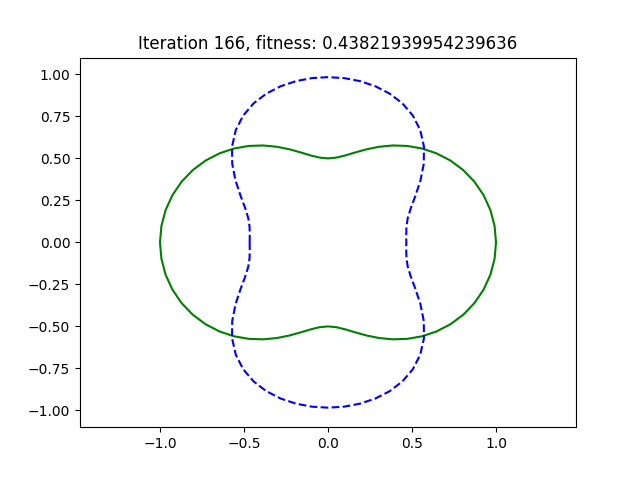

In [44]:
if DIM_2D:
    fig, ax = plt.subplots(1,1)
    ax.axis('equal')
    plot_interactive_object = PlotInteractive2D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas2pi,
        r_exact_vals = R_EXACT(collocation.thetas2pi)
    )
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ## TODO: set axis limits automaticly
    ax.set_xlim3d([-3, 3])
    ax.set_ylim3d([-3, 3])
    ax.set_zlim3d([-3, 3])
    plot_interactive_object = PlotInteractive3D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas,
        phis = collocation.phis2pi,
        r_exact_vals = R_EXACT(collocation.thetas, collocation.phis2pi)
    )

toolbox.register("plot", plot_approximation, plot_interactive = plot_interactive_object)

## Define execution model

In [45]:
def rModel(Npop, Ngen, Pcross, Pmut, initPopulation = None):    
    ## Optimal coeeficient is 40% of population size.
    ## See "Zbigniew Michalewicz Genetic Algorithms + Data structures = Evolutions Programs"
    changeSize = int(0.4*Npop)
        
    # create generator
    rng = np.random.default_rng()
    
    ## Generate new population if initial not specified
    if(initPopulation is None):
        population = toolbox.population(n=Npop)
    else:
        population  = initPopulation
    
    # saves best individual
    hof = tools.HallOfFame(1)
    
    # define statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
#     stats_size = tools.Statistics(len)
    stats_size = tools.Statistics(lambda ind: ind.height)
    
    stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size)
    
#     stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
#     logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "max", "std"
    logbook.chapters["height"].header = "min", "avg", "max"
    
    # Evaluate the entire population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
        
    # update hof
    hof.update(population)
    
    # register logbook
    record = stats.compile(population)
    logbook.record(gen=0, evals=len(population), **record)
    
    # print progress
    print(logbook.stream)
    
    for generation in range(1, Ngen):
        
        # select parents and copy them to offspring
        parents = toolbox.select_tournament(population, changeSize)
        
        offspring = [toolbox.clone(ind) for ind in parents]
        
        # select died elements and remove them from population
        to_die = toolbox.select_worst(population, changeSize)
        
        population = [ind for ind in population if not any(ind is copy for copy in to_die)]
        

        # apply crossover and mutation to create offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if rng.random() < Pcross:
                ind1,ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if rng.random() < Pmut:
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
        

        # Evaluate the individuals with an invalid fitness
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalids:
            ind.fitness.values = toolbox.evaluate(ind)
        
        # Replacement of the population by the offspring
        population.extend(offspring)
        
        hof.update(population)
        
        record = stats.compile(population)
        logbook.record(gen=generation, evals=len(invalids), **record)
        
        print(logbook.stream)
        
        ## plot current solution
        toolbox.plot(hof[0],title = f'Iteration {generation}, fitness: {hof[0].fitness.values[0]}')
    return population, logbook, hof

In [46]:
if __name__ == "__main__":
    population, logbook, hof = rModel(Npop = 1000,
                                  Ngen = 500,
                                  Pcross = 0.6,
                                  Pmut = 0.45)

   	     	               fitness                	       height      
   	     	--------------------------------------	-------------------
gen	evals	min    	avg    	max        	std   	min	avg  	max
0  	1000 	99.3039	96482.9	3.07358e+06	198526	1  	1.865	3  
1  	288  	99.3039	39858.2	904080     	89341.9	0  	1.981	6  
2  	294  	96.2886	38333.2	4.0578e+06 	229143 	0  	2.124	7  
3  	311  	96.2886	17322  	1.17827e+06	97669.3	0  	2.245	7  
4  	302  	74.9601	9202.26	904080     	65122.6	0  	2.342	7  
5  	302  	74.9601	13990.6	904080     	85603.2	0  	2.572	7  
6  	301  	74.9601	279032 	2.66805e+08	8.43291e+06	1  	2.86 	9  
7  	285  	74.9601	15294.2	1.93691e+06	108134     	1  	2.818	8  
8  	295  	74.9601	35650  	2.12781e+07	679745     	0  	2.781	9  
9  	277  	74.9601	301513 	2.8856e+08 	9.1206e+06 	0  	2.709	8  
10 	310  	74.9601	10991  	904080     	75905.6    	0  	2.841	9  
11 	306  	74.9601	11861.2	1.36892e+06	87550      	0  	2.896	9  
12 	304  	74.9601	8933.13	904080     	73228.8    	1  	2.939	

120	312  	2.07502	4584.05    	904080     	33913.8    	1  	27.442	69 
121	314  	2.07502	3868.01    	100000     	19108.9    	0  	27.829	69 
122	308  	1.5354 	3328.49    	100000     	17596      	1  	26.917	69 
123	281  	1.5354 	4236.79    	100000     	19888.9    	1  	25.999	69 
124	286  	1.5354 	5241.73    	904080     	44039.3    	0  	25.323	69 
125	295  	1.5354 	3250.43    	100000     	17383.9    	2  	24.427	70 
126	300  	1.35538	3893.63    	100000     	19104.2    	1  	23.848	69 
127	312  	1.35538	5348.74    	605903     	28270.2    	0  	23.599	54 
128	305  	1.35538	4812.68    	904080     	34269.2    	1  	23.57 	69 
129	296  	1.35538	3155.23    	100000     	17121.1    	3  	22.403	69 
130	280  	0.839241	3799.97    	100000     	18859.8    	1  	20.711	69 
131	293  	0.839241	4385.12    	100000     	20112.1    	2  	20.66 	48 
132	316  	0.747859	4832.51    	904080     	34214.3    	0  	21.965	51 
133	299  	0.735691	4703.27    	904080     	34140.2    	0  	24.337	51 
134	310  	0.666727	6608.98    

MemoryError: DEAP : Error in tree evaluation : Python cannot evaluate a tree higher than 90. To avoid this problem, you should use bloat control on your operators. See the DEAP documentation for more information. DEAP will now abort.

In [ ]:
print(hof[0])